In [21]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler

import arviz as az

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

In [22]:
# get data     
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()
data['gdp_total_season_diff'] = data['gdp_total_season'].diff()
data.dropna(inplace=True)

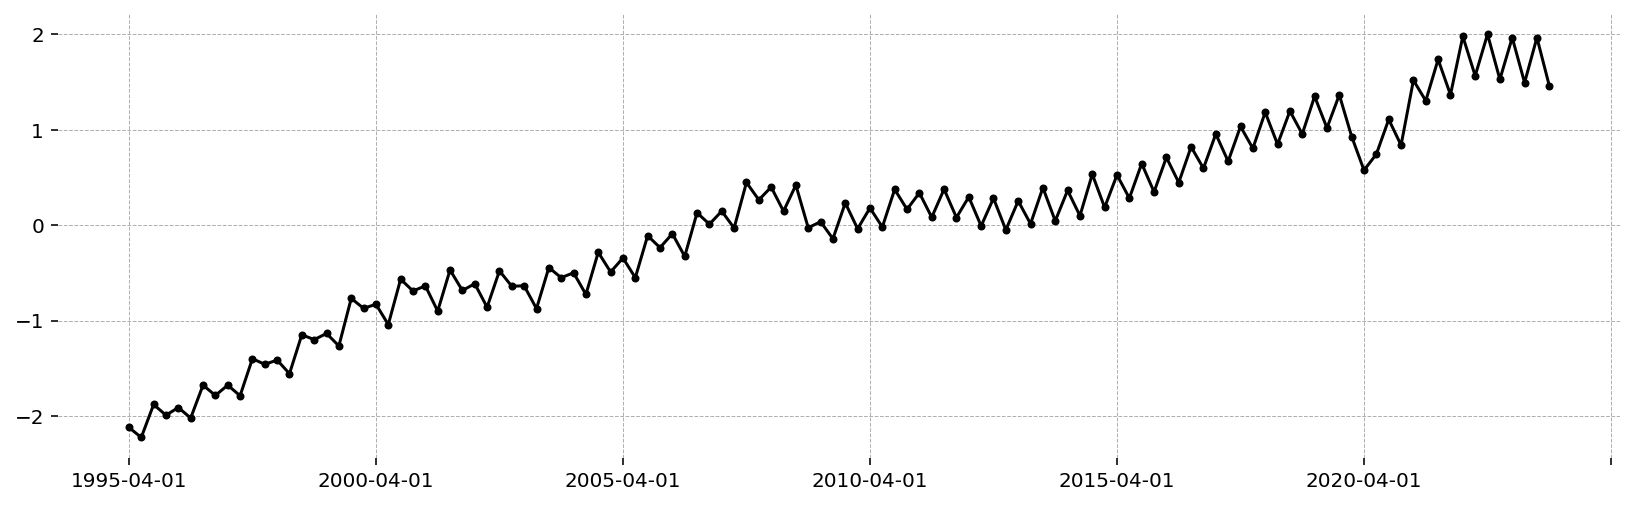

In [23]:
scaler = StandardScaler()

columns_Transform = ["gdp_total_season", "gdp_total_season_diff"]
data[columns_Transform] = scaler.fit_transform(data[columns_Transform])
data.columns = [cls + "_stdz" for cls in data.columns]
data['gdp_total_season_stdz'].plot(style=".-", color="k");

y = data['gdp_total_season_stdz'].values

In [25]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    rho = pm.Normal("rho", mu=0.0, sigma=1.0, shape=2)
    # precision of the innovation term
    tau = pm.Exponential("tau", lam=0.5)

    likelihood = pm.AR(
        "y", rho=rho, tau=tau, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata = pm.sample(1000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, tau]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


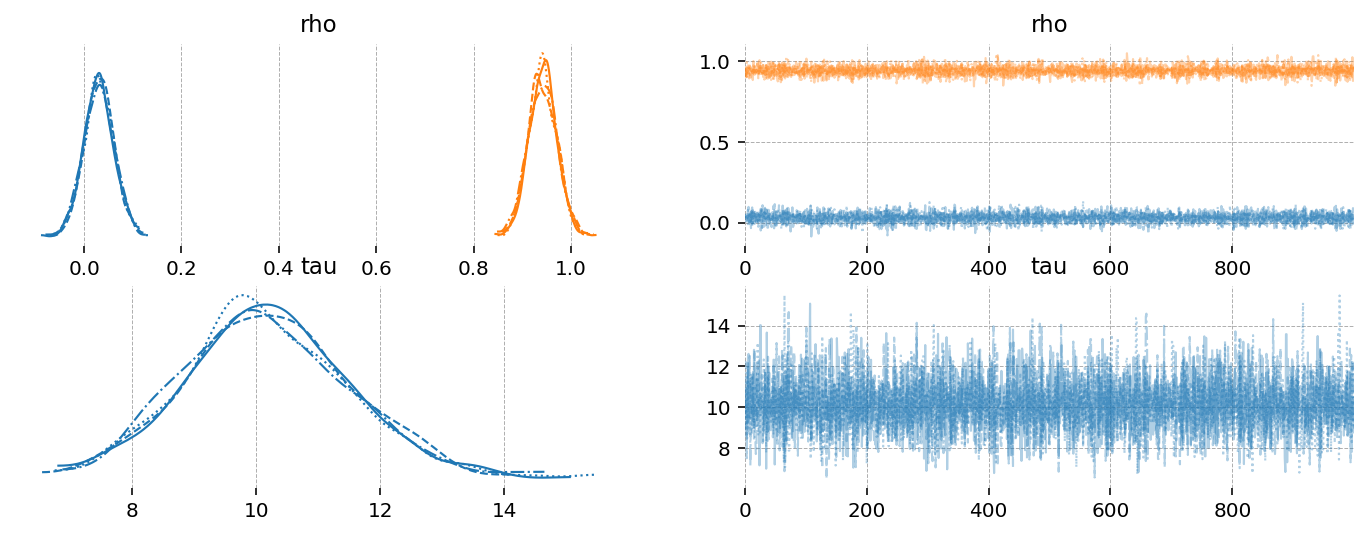

In [26]:
az.plot_trace(
    idata,
);

In [33]:
prediction_length = 134
n = prediction_length - y.shape[0]
obs = list(range(prediction_length))
with ar1:
    ## We need to have coords for the observations minus the lagged term to correctly centre the prediction step
    ar1.add_coords({"obs_id_fut_1": range(y.shape[0] - 1, 134, 1)})
    ar1.add_coords({"obs_id_fut": range(y.shape[0], 134, 1)})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.
    ar1_fut = pm.AR(
        "ar1_fut",
        init_dist=pm.DiracDelta.dist(ar1[..., -1]),
        rho=rho,
        sigma=tau,
        constant=True,
        dims="obs_id_fut_1",
    )
    yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
    )

AttributeError: 'tuple' object has no attribute 'endswith'